# Random Forest

## Imports

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
%matplotlib inline

## Dataset
Define training/testing set by subject

In [3]:
Dataset = pd.read_csv("final_dataset.csv", index_col=0)

train_test_limit = 40

X = Dataset.drop("Expression", axis = 1)
X[X<1e-2]=0
y = Dataset[["Subject number", "Expression"]]

X_train = X[X["Subject number"] < train_test_limit].drop("Subject number", axis = 1)
y_train = y[y["Subject number"] < train_test_limit]["Expression"]

X_test = X[X["Subject number"] >= train_test_limit].drop("Subject number", axis=1)
y_test = y[y["Subject number"] >= train_test_limit]["Expression"]

### Cross-evaluation algorithm

In [4]:
subjects = [x for x in range(53) if x != 7] # skip subject 7

def cross_val(model):
    scores = []
    for i in range(10):
        subject = random.choices(subjects, k=10)
        X_tr = X[~X["Subject number"].isin(subject)].drop("Subject number", axis=1)
        y_tr = y[~y["Subject number"].isin(subject)]["Expression"]
        X_te = X[X["Subject number"].isin(subject)].drop("Subject number", axis=1)
        y_te = y[y["Subject number"].isin(subject)]["Expression"]
        model.fit(X_tr, y_tr)
        scores.append(model.score(X_te, y_te))
    return np.array(scores)

## Hyperparameters tuning

### n_estimators

In [5]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

test_scores = []
training_scores = []

best_score = 0
best_n = 0

for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(X_train, y_train)
   score = rf.score(X_test, y_test)
   test_scores.append(score)
   training_scores.append(rf.score(X_train, y_train))

   if score > best_score : 
      best_n = estimator
      best_score = score

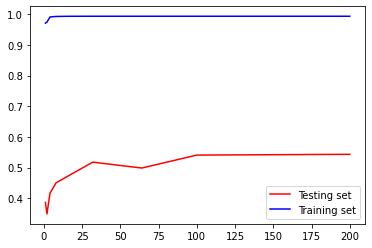

best n_estimator : 200


In [6]:
line1 = plt.plot(n_estimators, test_scores, 'r', label="Testing set")
line2 = plt.plot(n_estimators, training_scores, 'b', label="Training set")
plt.legend()
plt.show()
print("best n_estimator : " + str(best_n))

### max_depth

In [7]:
max_depths = np.linspace(1, 64, 64, endpoint=True)
training_results = []
test_results = []

best_score = 0
best_depth = 0

for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   rf.fit(X_train, y_train)
   training_results.append(rf.score(X_train, y_train))
   score = rf.score(X_test, y_test)
   test_results.append(score)
   if score > best_score : 
      best_score = score
      best_depth = max_depth

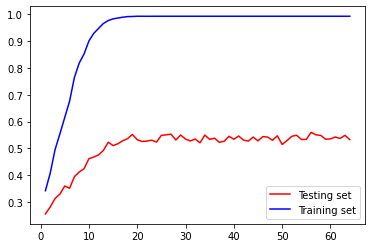

best max_depth : 56.0


In [8]:
line1 = plt.plot(max_depths, test_results, 'r', label="Testing set")
line2 = plt.plot(max_depths, training_results, 'b', label="Training set")
plt.legend()
plt.show()
print("best max_depth : " + str(best_depth))

## Final model

In [9]:
rf_model = RandomForestClassifier(n_estimators=best_n, max_depth=best_depth)
rf_model.fit(X_train, y_train)
print("accuracy : {}".format(rf_model.score(X_test, y_test)))

accuracy : 0.5431065842124408


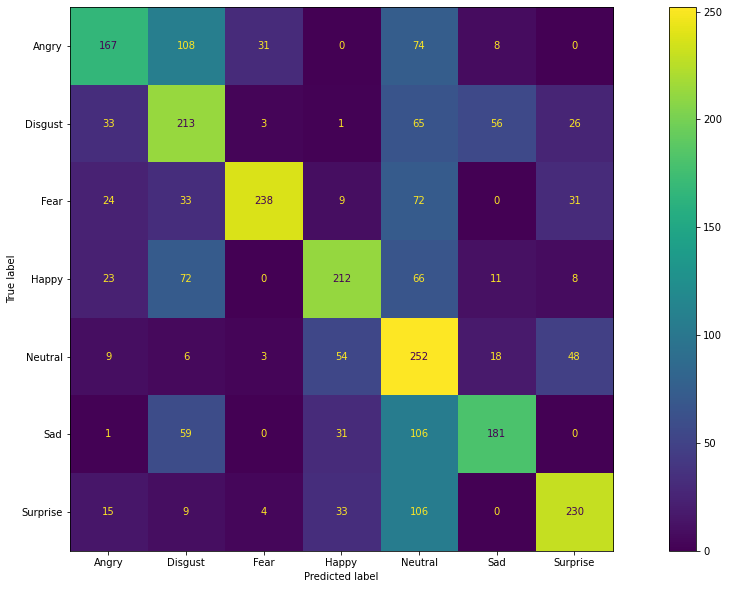

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
gbm_cm = ConfusionMatrixDisplay.from_predictions(y_test, rf_model.predict(X_test), ax=ax)

In [11]:
rf_cross_val_scores = cross_val(rf_model)
print(rf_cross_val_scores)
print("%0.2f mean accuracy with a standard deviation of %0.2f" % (rf_cross_val_scores.mean(), rf_cross_val_scores.std()))

[0.62060998 0.50677887 0.33048719 0.44472362 0.46996303 0.54062642
 0.51919087 0.45934579 0.45172825 0.48293173]
0.48 mean accuracy with a standard deviation of 0.07


## Final model + Export

In [12]:
rf_final_model = RandomForestClassifier(n_estimators=best_n, max_depth=best_depth)
rf_final_model.fit(X.drop("Subject number", axis=1), y["Expression"])

RandomForestClassifier(max_depth=56.0, n_estimators=200)

In [13]:
pickle.dump(rf_final_model, open("Exported_models/random_forest_model.sav", 'wb'))